In [19]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy import io
import torch
import torch.nn as nn
from torch.autograd import Variable

from instructor import Instructor
from cvx_net import CvxNet


plt.style.use('bmh')

#  QP layer and cvx net
## Some MPC costs are very large, which leads to bad regression in the region where the costs are very small. So I add the weights
## loss = weight(x)*(y-y_)^2
## weight: exp(-x^2/(2*std^2))
## changing place: at CvxNet: forward(), last several lines
## But infeasible errors happen, and I think it's not the problem of weight. It's because of the QP layer and soft MPC. We can find the error after training , shown below

In [20]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.nn.parameter import Parameter

import cvxpy as cp
from cvxpylayers.torch import CvxpyLayer

from matrix_square_root import sqrtm

def QP_layer(nz, nineq_u, nineq_x):
    """Builds the QP layer with MPC soft constraints.

    The optimization problem is of the form
        \hat z,\hat e  =   argmin_z z^T*Q*z + p^T*z + e^T*E*e
                subject to G1*z <= h1
                            G2*z <= h2+e
                
    where Q \in S^{nz,nz},
        S^{nz,nz} is the set of all positive semi-definite matrices,
        p \in R^{nz}
        G1 \in R^{nineq_u,nz}
        h1 \in R^{nineq_u}
        G2 \in R^{nineq_x,nz}
        h2 \in R^{nineq_x}
        E \in S^{ne,ne}, where ne = nineq_x
    
    Take the matrix square-root of Q：mentioned in paper P19
    (Differentiable Convex Optimization Layers).
    """
    Q_sqrt = cp.Parameter((nz, nz))
    p = cp.Parameter(nz)
    G1 = cp.Parameter((nineq_u, nz))
    h1 = cp.Parameter(nineq_u)
    G2 = cp.Parameter((nineq_x, nz))
    h2 = cp.Parameter(nineq_x)
    E_sqrt = cp.Parameter((nineq_x, nineq_x))
    z = cp.Variable(nz)
    e = cp.Variable(nineq_x)
    obj = cp.Minimize(cp.sum_squares(Q_sqrt*z) + p.T@z +
                     cp.sum_squares(E_sqrt*e))
    cons = [ G1@z <= h1,G2@z <= h2+e, e >= 0 ]
    prob = cp. Problem(obj, cons)
    assert prob.is_dpp()

    layer = CvxpyLayer (prob, 
                        parameters =[Q_sqrt, p, G1, h1, G2,
                                     h2, E_sqrt], 
                        variables =[ z, e ])
    return layer



class CvxNet(nn.Module):
    """Builds the strucre of the cvx net.
    
    The struture is x0-QP-[cost,u].
    """
    
    def __init__(self, num_input, num_output, num_u=5, cuda=False,collect=False):

        """Initiates OptNet."""
        super().__init__()
        self.num_input = num_input  # Dimension: x0
        self.num_output = num_output  # Dimension: u0
        self.num_u = num_u  # Dimension: u0,u1,...,uN
        self.cuda = cuda
        self.collect = collect
        
        self.N = int(self.num_u/self.num_output)  # get the number of the finite steps in MPC
        num_ineq_u = 2*num_u
        num_ineq_x = 2*num_input*self.N
        
        self.layer = QP_layer(num_u, num_ineq_u, num_ineq_x)
        
        self.Q_sqrt = Parameter(torch.rand(num_input, num_input),requires_grad=True)
        self.R_sqrt = Parameter(torch.rand(num_output,num_output),requires_grad=True)
        
        self.A = Parameter(torch.rand(num_input, num_input),requires_grad=True)
        self.B = Parameter(torch.rand(num_input, num_output),requires_grad=True)

        self.h1 = Parameter(0.5*torch.ones(num_ineq_u),requires_grad=False)
        self.h21 = Parameter(4*torch.ones(num_input*self.N),requires_grad=False)
        self.h22 = Parameter(4*torch.ones(num_input*self.N),requires_grad=False)
        
        self.E_sqrt = Parameter(torch.eye(num_ineq_x),requires_grad=False)

        if collect==True:
            self.Q_sqrt = Parameter(torch.eye(num_input),requires_grad=True)
            self.R_sqrt = Parameter(torch.eye(num_output),requires_grad=True)
            self.A = Parameter(torch.Tensor([[1.0,1.0],[0,1.0]]),requires_grad=True)
            self.B = Parameter(torch.Tensor([[0.5],[1.0]]),requires_grad=True)
            self.h1 = Parameter(0.5*torch.ones(num_ineq_u),requires_grad=False)
            self.h21 = Parameter(4*torch.ones(num_input*self.N),requires_grad=False)
            self.h22 = Parameter(4*torch.ones(num_input*self.N),requires_grad=False)
                   
        weight = torch.zeros(num_u)
        weight[0] = 1.0
        self.weight = Parameter(weight,requires_grad=False)
            

    def forward(self, x):
        """Builds the forward strucre of the QPNet.
        Sequence: x0-QP-[cost,u].
        QP parameters: Q_sqrt, p, G, h
        """
        # input x0 and batch size 
        num_batch = x.size(0)
        x0 = x.view(num_batch, -1)
        
        A_hat = self.build_A_block()
        B_hat = self.build_B_block()
        
        # Q_sqrt in QP
        Q = self.Q_sqrt.mm(self.Q_sqrt.t())
        R = self.R_sqrt.mm(self.R_sqrt.t())
        R_diag = self.build_Rdiagnol_block(R)
        Q_hat, Q_diag = self.build_Q_block(Q, Q, R, B_hat)
        Q_sqrt_hat = sqrtm(Q_hat)  # computs sqrt of Q
        Q_sqrt_hat = Q_sqrt_hat.repeat(num_batch,1,1)  # builds batch
                
        # p in QP  p = 2 * (Q_diag*B_hat)^T * (A_hat*x0)
        A_x0 = A_hat.mm(x0.t()).t()  # presents[x1;x2;...;xN] size: batch * dim(x1;x2;...;xN)
        p = 2*A_x0.mm(Q_diag.mm(B_hat))
        
        # G in QP
        G1,G2 = self.build_G_block(B_hat)
        G1 = G1.repeat(num_batch,1,1)  # builds batch
        G2 = G2.repeat(num_batch,1,1)  # builds batch
        
        # h in QP
        h1 = self.h1.repeat(num_batch,1)  # builds batch
        h21 = self.h21.repeat(num_batch,1)  # builds batch
        h21 -= A_x0 
        h22 = self.h22.repeat(num_batch,1)  # builds batch
        h22 += A_x0
        h2 = torch.cat((h21,h22),1)
        
        # E in QP
        E = self.E_sqrt.mm(self.E_sqrt.t())
        E_sqrt = self.E_sqrt.repeat(num_batch,1,1)
        
        # gets the solution of the basic optimization problem
        self.Qr = Q_sqrt_hat
        self.para = [Q_sqrt_hat, p, G1, h1, G2,
                            h2, E_sqrt] 
        u_opt,e_opt, = self.layer(Q_sqrt_hat, p, G1, h1, G2, h2, 
                            E_sqrt)  # size: batch*dim(u)
        
        # get the optimal cost
        # a+b: sum(i:1 to N): xi^T*Q*xi + u(i-1)^T*R*u(i-1)
        # c: x0^T*Q*x0
        # d:(i:1 to N):ei^T*E*ei
        a = (u_opt.mm(Q_hat)*u_opt + p*u_opt).sum(1)
        b = (A_x0.mm(Q_diag)*A_x0).sum(1)
        c = (x0.mm(Q)*x0).sum(1)
        d = (e_opt.mm(E)*e_opt).sum(1)
        cost_opt = (a+b+c+d).unsqueeze(1)  # size: batch*1
        # u0 = u_opt.mv(self.weight).unsqueeze(1)  # only the fisrt action
        #print(x0.size())
        reg_weight = torch.exp(-(x0*x0).sum(1)/4.0).unsqueeze(1) 
#         print(reg_weight)
#         print(cost_opt)
        cost_and_u = torch.cat((reg_weight*cost_opt,u_opt),1)
        
        return cost_and_u
    
    def build_A_block(self):
        """
        [A]
        [A^2] 
        [A^3]
        [...]
        """
        N = self.N  # number of MPC steps
        A = self.A
        
        row_list = [A]  # reocrd the every row in B_hat
        
        for i in range(1, N):
            A = A.mm(self.A)
            row_list.append(A)
        return torch.cat(row_list,0)
    
    def build_B_block(self):
        """In MPC, express x vector in u vector and compute the new big B_hat matrix
        [B 0 0 ...
        [AB B 0
        ...
        """

        N = self.N  # number of MPC steps
        row_list = []  # reocrd the every row in B_hat
        
        first_block = self.B
        zero = Variable(torch.zeros(self.num_input, self.num_output*(N-1)))
        zero = self.vari_gpu(zero)
        row= torch.cat([first_block, zero],1)
        row_list.append(row)
        
        for i in range(1, N):
            first_block = self.A.mm(first_block)
            row = torch.cat([first_block, row[:,:self.num_output*(N-1)]],1)
            row_list.append(row)  
            
        return torch.cat(row_list,0)
        
        
    def build_Qdiagnol_block(self, Q, P):
        """ (num_imput*N) x (num_imput*N)
        The last block is P for x(N)"""
        
        N = self.N  # number of MPC steps
        num_input = self.num_input
        
        row_list = []  # reocrd the every row in B_hat
        zero = Variable(torch.zeros(num_input, num_input*(N-1)))
        zero = self.vari_gpu(zero)
        row_long = torch.cat([zero, Q, zero],1)  # [0 0 ... Q 0 0 ...]
        for i in range(N, 1, -1):
            row_list.append(row_long[:, (i-1)*num_input : (i+N-1)*num_input])
            
        row = torch.cat([zero, P],1)  # last line by [0 P]
        row_list.append(row)
        
        return torch.cat(row_list,0)
    
    def build_Rdiagnol_block(self, R):
        """
        [R 0 0 ...
        [0 R 0
        ...
        """
        N = self.N  # number of MPC steps
        num_output = self.num_output
        
        row_list = []  # reocrd the every row in B_hat
        zero = Variable(torch.zeros(num_output, num_output*(N-1)))
        zero = self.vari_gpu(zero)
        row_long = torch.cat([zero, R, zero],1)  # [0 0 ... Q 0 0 ...]
        
        for i in range(N, 0, -1):
            row_list.append(row_long[:, (i-1)*num_output : (i+N-1)*num_output])
        return torch.cat(row_list,0)
        
    def build_Q_block(self, Q, P, R, B_hat):
        """Build the Q_hat matrix so that MPC is tranfered into basic optimization problem
        Q_hat = B_hat^T * diag(Q) * B_hat + diag(R)
        """
        Q_diag = self.build_Qdiagnol_block(Q,P)
        R_diag = self.build_Rdiagnol_block(R)
        Q_hat = B_hat.t().mm(Q_diag.mm(B_hat)) + R_diag
        return Q_hat,Q_diag 
        
        
    def build_G_block(self,B_hat):
        """Build the G matrix so that MPC is tranfered into basic optimization problem
        G1 = [eye(num_u)]
             [-eye(num_u)]
        G2 = [   B_hat  ]
             [  -B_hat  ]
        """
        
        eye = Variable(torch.eye(self.num_u))
        eye = self.vari_gpu(eye)
        G1 = torch.cat((eye, -eye), 0)
        G2 = torch.cat((B_hat, -B_hat), 0)
        # print(self.B_hat)
        # print(G.size())
        return G1,G2
    
    def vari_gpu(self, var):
        if self.cuda:
            var = var.cuda()
            
        return var

# Training

In [21]:
# reads the datasets from the file
cuda = False

npzfile=np.load('dbin_std2_cost.npz')  # std^2 = 2 
x0 = npzfile['x'] 
c_u = npzfile['cost_u'] 
print("shape of x0:",x0.shape," |shape of [cost, u]:",c_u.shape)

shape of x0: (10201, 2)  |shape of [cost, u]: (10201, 6)


In [22]:
x = Variable(torch.from_numpy(x0).float(), requires_grad=False)
y = Variable((torch.from_numpy(c_u[:,:])).float(), requires_grad=False)
if cuda:
    x = x.cuda()
    y = y.cuda()
print("Example, x:", x[100], " |cost_u[0]:",y[100,:])

# split the dataset into train and test
dataset = torch.utils.data.TensorDataset(x,y)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
print("train size:",len(train_dataset)," |test size:",len(test_dataset))

# shuffle the data, build dataset batches
batch_size = 80
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=True)

Example, x: tensor([-5.,  5.])  |cost_u[0]: tensor([ 0.0025, -0.5000, -0.5000, -0.5000, -0.5000, -0.5000])
train size: 8160  |test size: 2041


In [37]:
# Initialize the model.

dim_inp = x0.shape[1]
dim_out = 1
model = CvxNet(dim_inp, dim_out,collect=False,cuda=cuda)
device = torch.device("cuda:0" if cuda else "cpu")
model = model.to(device)
loss_fun = torch.nn.MSELoss() # Initialize the loss function

# Initialize the optimizer.
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

losses_train = []
losses_test = []
instructor = Instructor(model, optimizer, loss_fun)
run_loss = 0.0


In [38]:
print('A',model.A)
print('B',model.B)
print('Q',model.Q_sqrt.mm(model.Q_sqrt.t()))
print('R',model.R_sqrt.mm(model.R_sqrt.t()))
print('h1',model.h1)
print('h21',model.h21)
print('h22',model.h22)

A Parameter containing:
tensor([[0.3717, 0.0470],
        [0.4149, 0.2971]], requires_grad=True)
B Parameter containing:
tensor([[0.6904],
        [0.3952]], requires_grad=True)
Q tensor([[0.8304, 0.0843],
        [0.0843, 0.0087]], grad_fn=<MmBackward>)
R tensor([[0.0125]], grad_fn=<MmBackward>)
h1 Parameter containing:
tensor([0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000])
h21 Parameter containing:
tensor([4., 4., 4., 4., 4., 4., 4., 4., 4., 4.])
h22 Parameter containing:
tensor([4., 4., 4., 4., 4., 4., 4., 4., 4., 4.])


### One good training

In [25]:
for epoch in range(30):
    loss_train, run_loss = instructor.train(train_loader,epoch,run_loss)
    loss_test = instructor.evaluate(test_loader)
    losses_train.append(loss_train)
    losses_test.append(loss_test)
    print('[epoch: %d] training loss: %.3f, testing loss: %.3f' %
                      (epoch + 1, loss_train, loss_test))

[epoch: 1,   100] training loss: 47.457
[epoch: 1] training loss: 47.522, testing loss: 35.978
[epoch: 2,   100] training loss: 19.536
[epoch: 2] training loss: 18.316, testing loss: 11.925
[epoch: 3,   100] training loss: 10.342
[epoch: 3] training loss: 10.160, testing loss: 9.243
[epoch: 4,   100] training loss: 7.988
[epoch: 4] training loss: 7.762, testing loss: 7.000
[epoch: 5,   100] training loss: 5.989
[epoch: 5] training loss: 5.872, testing loss: 5.206
[epoch: 6,   100] training loss: 4.500
[epoch: 6] training loss: 4.393, testing loss: 3.946
[epoch: 7,   100] training loss: 3.440
[epoch: 7] training loss: 3.330, testing loss: 2.923
[epoch: 8,   100] training loss: 2.580
[epoch: 8] training loss: 2.516, testing loss: 2.216
[epoch: 9,   100] training loss: 1.977
[epoch: 9] training loss: 1.936, testing loss: 1.672
[epoch: 10,   100] training loss: 1.551
[epoch: 10] training loss: 1.513, testing loss: 1.311
[epoch: 11,   100] training loss: 1.248
[epoch: 11] training loss: 1.2

In [26]:
for epoch in range(30):
    loss_train, run_loss = instructor.train(train_loader,epoch,run_loss)
    loss_test = instructor.evaluate(test_loader)
    losses_train.append(loss_train)
    losses_test.append(loss_test)
    print('[epoch: %d] training loss: %.3f, testing loss: %.3f' %
                      (epoch + 1, loss_train, loss_test))

[epoch: 1,   100] training loss: 0.321
[epoch: 1] training loss: 0.314, testing loss: 0.294
[epoch: 2,   100] training loss: 0.303
[epoch: 2] training loss: 0.297, testing loss: 0.283
[epoch: 3,   100] training loss: 0.281
[epoch: 3] training loss: 0.274, testing loss: 0.254
[epoch: 4,   100] training loss: 0.261
[epoch: 4] training loss: 0.256, testing loss: 0.235
[epoch: 5,   100] training loss: 0.242
[epoch: 5] training loss: 0.237, testing loss: 0.219
[epoch: 6,   100] training loss: 0.224
[epoch: 6] training loss: 0.219, testing loss: 0.202
[epoch: 7,   100] training loss: 0.210
[epoch: 7] training loss: 0.204, testing loss: 0.191
[epoch: 8,   100] training loss: 0.192
[epoch: 8] training loss: 0.188, testing loss: 0.173
[epoch: 9,   100] training loss: 0.178
[epoch: 9] training loss: 0.174, testing loss: 0.161
[epoch: 10,   100] training loss: 0.165
[epoch: 10] training loss: 0.162, testing loss: 0.150
[epoch: 11,   100] training loss: 0.152
[epoch: 11] training loss: 0.149, test

In [27]:
for epoch in range(30):
    loss_train, run_loss = instructor.train(train_loader,epoch,run_loss)
    loss_test = instructor.evaluate(test_loader)
    losses_train.append(loss_train)
    losses_test.append(loss_test)
    print('[epoch: %d] training loss: %.3f, testing loss: %.3f' %
                      (epoch + 1, loss_train, loss_test))

[epoch: 1,   100] training loss: 0.054
[epoch: 1] training loss: 0.053, testing loss: 0.051
[epoch: 2,   100] training loss: 0.052
[epoch: 2] training loss: 0.051, testing loss: 0.056
[epoch: 3,   100] training loss: 0.051
[epoch: 3] training loss: 0.050, testing loss: 0.047
[epoch: 4,   100] training loss: 0.048
[epoch: 4] training loss: 0.047, testing loss: 0.046
[epoch: 5,   100] training loss: 0.046
[epoch: 5] training loss: 0.045, testing loss: 0.045
[epoch: 6,   100] training loss: 0.045
[epoch: 6] training loss: 0.044, testing loss: 0.047
[epoch: 7,   100] training loss: 0.045
[epoch: 7] training loss: 0.044, testing loss: 0.044
[epoch: 8,   100] training loss: 0.043
[epoch: 8] training loss: 0.043, testing loss: 0.040
[epoch: 9,   100] training loss: 0.041
[epoch: 9] training loss: 0.040, testing loss: 0.039
[epoch: 10,   100] training loss: 0.040
[epoch: 10] training loss: 0.039, testing loss: 0.039
[epoch: 11,   100] training loss: 0.040
[epoch: 11] training loss: 0.039, test

### infeasible

In [39]:
for epoch in range(50):
    loss_train, run_loss = instructor.train(train_loader,epoch,run_loss)
    loss_test = instructor.evaluate(test_loader)
    losses_train.append(loss_train)
    losses_test.append(loss_test)
    print('[epoch: %d] training loss: %.3f, testing loss: %.3f' %
                      (epoch + 1, loss_train, loss_test))

[epoch: 1,   100] training loss: 54.784
[epoch: 1] training loss: 55.041, testing loss: 52.144
[epoch: 2,   100] training loss: 47.724
[epoch: 2] training loss: 46.011, testing loss: 31.730
[epoch: 3,   100] training loss: 27.041
[epoch: 3] training loss: 26.511, testing loss: 22.469
[epoch: 4,   100] training loss: 18.530
[epoch: 4] training loss: 17.866, testing loss: 15.065
[epoch: 5,   100] training loss: 12.125
[epoch: 5] training loss: 11.837, testing loss: 9.936
[epoch: 6,   100] training loss: 8.015
[epoch: 6] training loss: 7.769, testing loss: 6.589
[epoch: 7,   100] training loss: 5.289
[epoch: 7] training loss: 5.161, testing loss: 4.319
Please consider re-formulating your problem so that it is always solvable.


SolverError: Solver scs returned status Infeasible/Inaccurate

## Infeasible error happens.
## We can get the parameters for QP layer 
## However, use QP without e>=0, it may work. Some e is very small and negative. 
## I still don't find the bugs.

In [45]:
def QP_layer_e(nz, nineq_u, nineq_x):
    """
    without e>=0
    """
    Q_sqrt = cp.Parameter((nz, nz))
    p = cp.Parameter(nz)
    G1 = cp.Parameter((nineq_u, nz))
    h1 = cp.Parameter(nineq_u)
    G2 = cp.Parameter((nineq_x, nz))
    h2 = cp.Parameter(nineq_x)
    E_sqrt = cp.Parameter((nineq_x, nineq_x))
    z = cp.Variable(nz)
    e = cp.Variable(nineq_x)
    obj = cp.Minimize(cp.sum_squares(Q_sqrt*z) + p.T@z +
                     cp.sum_squares(E_sqrt*e))
    cons = [ G1@z <= h1,G2@z <= h2+e ]
    prob = cp. Problem(obj, cons)
    assert prob.is_dpp()

    layer = CvxpyLayer (prob, 
                        parameters =[Q_sqrt, p, G1, h1, G2,
                                     h2, E_sqrt], 
                        variables =[ z, e ])
    return layer

In [46]:
[Q1,p1,G11,h11,G21,h21,E1]=model.para
layer = QP_layer_e(5, 10, 20)

# solution
u,e, = layer ( Q1,p1,G11,h11,G21,h21,E1)

In [47]:
e

tensor([[-1.3689e-06, -1.0391e-06, -4.1972e-07,  ..., -1.2722e-06,
         -4.6699e-07, -1.1421e-06],
        [-6.0254e-06, -2.2534e-06, -7.5293e-06,  ...,  3.9743e-06,
          7.3903e-06,  9.4566e-06],
        [ 5.7636e-01,  2.3828e+00,  1.6583e+00,  ...,  9.0072e-06,
          3.6902e-06,  5.6213e-06],
        ...,
        [ 8.2756e-08,  6.2092e-08,  1.1473e-07,  ...,  4.6703e+00,
          3.6536e+00,  7.1808e+00],
        [-2.5773e-11, -9.8860e-12,  1.8823e-11,  ...,  9.4848e-12,
          5.7515e-14,  1.3030e-11],
        [-3.3920e-09, -1.3608e-09, -1.0521e-08,  ..., -2.9895e-08,
         -5.9436e-08, -5.5519e-08]], grad_fn=<_CvxpyLayerFnFnBackward>)

# Some visualization

In [28]:
print('A',model.A)
print('B',model.B)
print('Q',model.Q_sqrt.mm(model.Q_sqrt.t()))
print('R',model.R_sqrt.mm(model.R_sqrt.t()))
print('h1',model.h1)
print('h21',model.h21)
print('h22',model.h22)

A Parameter containing:
tensor([[0.5175, 1.2965],
        [0.1450, 0.8917]], requires_grad=True)
B Parameter containing:
tensor([[0.6387],
        [1.1189]], requires_grad=True)
Q tensor([[2.4645, 1.1068],
        [1.1068, 0.5364]], grad_fn=<MmBackward>)
R tensor([[1.5847]], grad_fn=<MmBackward>)
h1 Parameter containing:
tensor([0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000])
h21 Parameter containing:
tensor([4., 4., 4., 4., 4., 4., 4., 4., 4., 4.])
h22 Parameter containing:
tensor([4., 4., 4., 4., 4., 4., 4., 4., 4., 4.])


(0.0, 49.896865827403964)

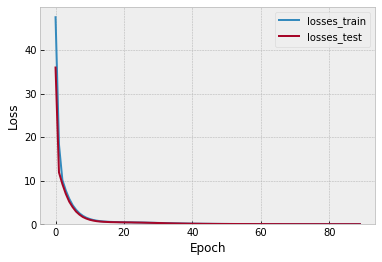

In [29]:
plt.plot(losses_train, label='losses_train')
plt.plot(losses_test, label='losses_test')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.ylim(ymin=0.)

In [36]:
model.eval()
with torch.no_grad():
    for n, (inp, out) in enumerate(test_loader):
        out_pre = model(inp[1,:].unsqueeze(0))
        print('input: ',inp[1,:])
        print('pre: ',out_pre)
        print('true: ',out[1,:])
        print('\n\n\n')

input:  tensor([ 1.2000, -3.1000])
pre:  tensor([[14.5253,  0.5000,  0.5000,  0.5000,  0.5000,  0.5000]])
true:  tensor([14.3471,  0.5000,  0.5000,  0.5000,  0.5000,  0.5000])




input:  tensor([3.7000, 1.3000])
pre:  tensor([[ 2.9797, -0.5000, -0.5000, -0.5000, -0.5000, -0.5000]])
true:  tensor([ 3.0604, -0.5000, -0.5000, -0.5000, -0.5000, -0.5000])




input:  tensor([0.1000, 1.4000])
pre:  tensor([[11.1847, -0.5000, -0.5000, -0.5000, -0.1326,  0.0554]])
true:  tensor([11.0877, -0.5000, -0.5000, -0.5000, -0.5000,  0.0222])




input:  tensor([-1.1000, -3.9000])
pre:  tensor([[14.1062,  0.5000,  0.5000,  0.5000,  0.5000,  0.5000]])
true:  tensor([14.0816,  0.5000,  0.5000,  0.5000,  0.5000,  0.5000])




input:  tensor([ 2.2000, -4.2000])
pre:  tensor([[2.0600, 0.5000, 0.5000, 0.5000, 0.5000, 0.5001]])
true:  tensor([2.0458, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000])




input:  tensor([ 4.8000e+00, -1.7764e-14])
pre:  tensor([[ 0.2269, -0.5000, -0.5000, -0.1641,  0.0813,  0.0174]])
tr

In [31]:
from matplotlib import cm
import matplotlib.pyplot as plt
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D

shape of x0: (10201, 2)  |shape of [cost, u]: (10201, 6)
Example, x: tensor([-5., -5.])  |cost_u[0]: tensor([0.0102, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000])
pre:  torch.Size([10201, 6])


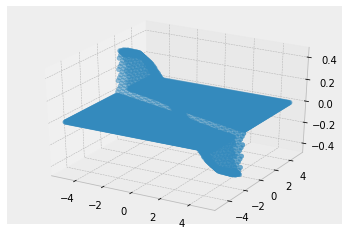

In [32]:
# get x0, u0 from dataset
print("shape of x0:",x0.shape," |shape of [cost, u]:",c_u.shape)
X1 = x0[:,0]
X2 = x0[:,1]
U0 = c_u[:,1]

x = Variable(torch.from_numpy(x0).float(), requires_grad=False)
y = Variable((torch.from_numpy(c_u[:,:])).float(), requires_grad=False)
if cuda:
    x = x.cuda()
    y = y.cuda()
print("Example, x:", x[0], " |cost_u[0]:",y[0,:])
model.eval()
with torch.no_grad():
    out_pre = model(x)
    print('pre: ',out_pre.size())
U0_pre = out_pre[:,1].cpu().numpy()

# print u0-u0_pre
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X1, X2, U0-U0_pre,cmap=cm.coolwarm)
# ax.scatter(X1, X2,U0_pre )


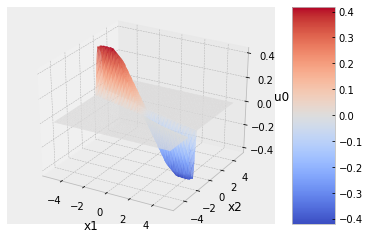

In [33]:

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_trisurf(X1, X2, U0-U0_pre,cmap=cm.coolwarm )
plt.ylabel('x2')
plt.xlabel('x1')
ax.set_zlabel('u0  ')
# Customize the z axis.
#ax.set_zlim(-2, 2)
#ax.zaxis.set_major_locator(LinearLocator(10))
#ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=1, aspect=5)

plt.show()

Text(0.5, 0, 'u0  ')

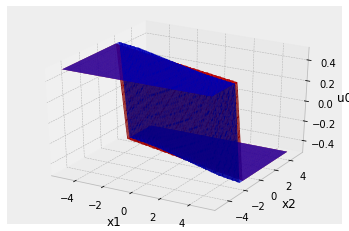

In [34]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(X1, X2, U0,color="b")
ax.plot_trisurf(X1, X2, U0_pre,color="r" )
plt.ylabel('x2')
plt.xlabel('x1')
ax.set_zlabel('u0  ')


# Collect MPC data by forward
Because MPC solutions by mpt and opt are different

In [214]:
# Initialize the model.
dim_inp = 2  # dimension of x
dim_out = 1  # dimension of u
num_u = 5  # N = num_u/dim_out
model = CvxNet(dim_inp, dim_out, num_u = 5, cuda=False, collect=True)
model.eval()
list_inp = []
list_out = []
u_max = 1.0
with torch.no_grad():
    for x1 in np.arange(-5.0,5.1,0.1):
        for x2 in np.arange(-5.0,5.1,0.1):
            try:
                inp = torch.tensor([x1,x2]).unsqueeze(0)
                out = model(inp)
    #             if (out[0,1]<=u_max and out[0,1]>=-u_max and
    #                 out[0,2]<=u_max and out[0,2]>=-u_max and
    #                 out[0,3]<=u_max and out[0,3]>=-u_max and
    #                 out[0,4]<=u_max and out[0,4]>=-u_max and
    #                 out[0,5]<=u_max and out[0,5]>=-u_max):
                list_inp.append(inp.numpy())
                list_out.append(out.numpy())
            except:
                print('This initial state is infeasible:[%f，%f]'%(x1,x2))           

#             print('input: ',inp[0,:])
#             print('pre: ',out)
#             print('\n')

In [215]:
inp_ = np.array(list_inp).squeeze()
out_ = np.array(list_out).squeeze()
np.savez('dbin_d4_cost.npz',x=inp_,cost_u=out_) 

In [83]:
npzfile=np.load('dbin_weighted_cost.npz') 
x0 = npzfile['x'] 
c_u = npzfile['cost_u'] 
print("shape of x0:",x0.shape," |shape of [cost, u]:",c_u.shape)
x = Variable(torch.from_numpy(x0).float(), requires_grad=False)
y = Variable((torch.from_numpy(c_u[:,:])).float(), requires_grad=False)
if cuda:
    x = x.cuda()
    y = y.cuda()
print("Example, x:", x[100], " |cost_u[0]:",y[100,:])

shape of x0: (10201, 2)  |shape of [cost, u]: (10201, 6)
Example, x: tensor([-5.,  5.])  |cost_u[0]: tensor([ 1.2732, -0.5000, -0.5000, -0.5000, -0.5000, -0.5000])


shape of x0: (10201, 2)  |shape of [cost, u]: (10201, 6)


Text(0.5, 0, 'u0  ')

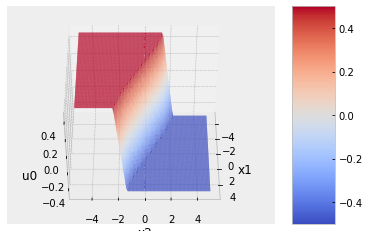

In [61]:
from matplotlib import cm
import matplotlib.pyplot as plt
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D
# get x0, u0 from dataset
print("shape of x0:",x0.shape," |shape of [cost, u]:",c_u.shape)
X1 = x0[:,0]
X2 = x0[:,1]
U0 = c_u[:,1]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_trisurf(X1, X2, U0,cmap=cm.coolwarm )
ax.view_init(elev=45,azim=0)
fig.colorbar(surf, shrink=1, aspect=5)
plt.ylabel('x2')
plt.xlabel('x1')
ax.set_zlabel('u0  ')
